# Pharmaceutical Manufacturing Outsourcing Optimization
## Background
This project seeks to approach a common pharmaceutical industry challenge of scaling a drug to production after FDA approval. 
There is urgency in the process of scaling to production because after filing, the patent for the drug is only held by the company for 10 years 
and vertically integrating is no longer the most economically viable option. 3rd party vendors must be employed to sequentially 
build the molecule over many steps that results in the active pharmaceutical ingredient (API). Selection of these vendors can be 
a strenous and inefficient process to work out as dozens of steps is common to build an API, however if each vendor is modeled by a
set of parameters, computational optimization is the perfect tool to rapidly determine the third party vendor sequence for API 
construction that allows for the pharma company to realize the maximum profit the patent is able to produce within the 10 year period.



In [215]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from networkx.drawing.nx_agraph import graphviz_layout
import re

In [216]:
#TODO: think about units
#TODO: build it as a class

## Using pyo.set

In [217]:
def optimize(prod_cost_csv, demand):
    """
    prod_cost_csv: CSV with columns [Step,Vendor,Production,Cost]
    demand:        scalar total demand
    """
    # 1) load everything in one go
    df = pd.read_csv(prod_cost_csv)

    # 2) reconstruct your vendors dict: { step: [opt1,opt2,...], ... }
    vendors = df.groupby("step")["Vendor"].apply(list).to_dict()

    # 3) flatten the (step,option) pairs
    pairs = list(df[["step","Vendor"]].itertuples(index=False, name=None))

    # 4) build lookup dicts for production & cost
    prod_dict = {
        (row.step, row.Vendor): row.Production
        for row in df.itertuples()
    }
    cost_dict = {
        (row.step, row.Vendor): row.Cost
        for row in df.itertuples()
    }

    # 5) build the Pyomo model
    m = pyo.ConcreteModel()
    m.steps       = pyo.Set(initialize=vendors.keys())
    m.step_option = pyo.Set(dimen=2, initialize=pairs)

    m.production = pyo.Param(m.step_option, initialize=prod_dict, within=pyo.NonNegativeReals)
    m.cost       = pyo.Param(m.step_option, initialize=cost_dict, within=pyo.NonNegativeReals)
    m.demand     = pyo.Param(initialize=demand,      within=pyo.NonNegativeReals)

    m.x = pyo.Var(m.step_option, domain=pyo.Binary)

    # exactly one option per step
    def one_per_group(m, step):
        return sum(m.x[step, opt] for opt in vendors[step]) == 1
    m.one_per_group = pyo.Constraint(m.steps, rule=one_per_group)

    # satisfy total demand
    def prod_level(m):
        return sum(m.production[s,o] * m.x[s,o] for s,o in m.step_option) >= m.demand
    m.prod_level = pyo.Constraint(rule=prod_level)

    # minimize total cost
    m.obj = pyo.Objective(
        expr=sum(m.cost[s,o] * m.x[s,o] for s,o in m.step_option),
        sense=pyo.minimize
    )

    return m, vendors


In [ ]:
model, vendors = optimize("test-data-combo.csv", 200)

solver = pyo.SolverFactory("gurobi")
solver.solve(model)
model.display()

with open("model_output.txt", "w") as f:
    # this writes variables, objectives and constraints
    model.display(ostream=f)

Model unknown

  Variables:
    x : Size=8, Index=step_option
        Key      : Lower : Value : Upper : Fixed : Stale : Domain
        (1, 'A') :     0 :   1.0 :     1 : False : False : Binary
        (1, 'B') :     0 :   0.0 :     1 : False : False : Binary
        (2, 'A') :     0 :   0.0 :     1 : False : False : Binary
        (2, 'B') :     0 :   0.0 :     1 : False : False : Binary
        (2, 'C') :     0 :   0.0 :     1 : False : False : Binary
        (2, 'D') :     0 :   1.0 :     1 : False : False : Binary
        (3, 'X') :     0 :   1.0 :     1 : False : False : Binary
        (3, 'Y') :     0 :   0.0 :     1 : False : False : Binary

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True :  60.0

  Constraints:
    one_per_group : Size=3
        Key : Lower : Body : Upper
          1 :   1.0 :  1.0 :   1.0
          2 :   1.0 :  1.0 :   1.0
          3 :   1.0 :  1.0 :   1.0
    prod_level : Size=1
        Key  : Lower

## Visualize

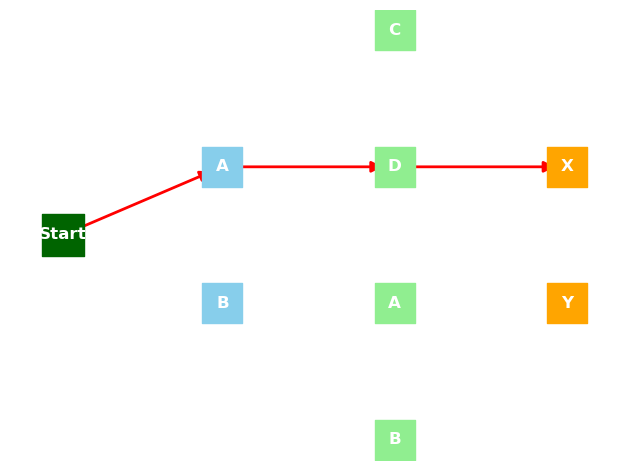

In [219]:
# --- 1) parse your model_output.txt into solution dict -----------
sol_pattern = re.compile(
    r"\(\s*(?P<step>\d+)\s*,\s*'(?P<option>[^']+)'\s*\)"
    r"\s*:\s*\d+\s*:\s*(?P<val>[0-9.]+)"
)
solution = {}
with open("model_output.txt") as f:
    for line in f:
        m = sol_pattern.search(line)
        if not m: 
            continue
        step = int(m.group("step"))
        opt  = m.group("option")
        val  = float(m.group("val"))
        solution[(step, opt)] = val
# --- 2) your vendors dict (can be any length) -------------------

# sort steps by their numeric suffix
import re
steps = sorted(vendors.keys())

# --- 3) build graph with invisible edges to force columns -------
G = nx.DiGraph()
START = 'Start'
G.add_node(START)

# add all option-nodes, keyed by (step, option)
for step in steps:
    for opt in vendors[step]:
        G.add_node((step, opt))

# invisibly chain: Step_N → Step_{N-1} → … → Step_1 → Start
for idx, step in enumerate(steps):
    targets = [START] if idx == 0 else [(steps[idx-1], o) for o in vendors[steps[idx-1]]]
    for u in vendors[step]:
        for v in targets:
            G.add_edge((step, u), v, style='invis')

# --- 4) extract chosen nodes & build the “real” edges -----------
# get (step, opt) tuples where x==1, ordered by step
chosen = sorted(
    [(st, opt) for (st, opt), val in solution.items() if val == 1],
    key=lambda x: x[0]
)

real_edges = []
# Start → first chosen
if chosen:
    real_edges.append((START, chosen[0]))
# then chain each step-to-step
for a, b in zip(chosen, chosen[1:]):
    real_edges.append((a, b))

# --- 5) layout & drawing ----------------------------------------
pos = graphviz_layout(G, prog='dot', args='-Grankdir=RL')

# draw only the real selection-path in red
nx.draw_networkx_edges(
    G, pos,
    edgelist=real_edges,
    arrowstyle='-|>',
    arrowsize=16,
    edge_color='red',
    width=2
)

# draw each “column” of nodes in its own color
#   left-most = last step, …, right-most = Start
colors = ['skyblue', 'lightgreen', 'orange', 'violet', 'gold']  # cycle if you like
for idx, step in enumerate(steps):
    col = [(step, o) for o in vendors[step]]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=col,
        node_color=colors[idx % len(colors)],
        node_shape='s',
        node_size=800
    )
# finally draw the Start node
nx.draw_networkx_nodes(
    G, pos,
    nodelist=[START],
    node_color='darkgreen',
    node_shape='s',
    node_size=900
)

# labels
labels = {START: 'Start'}
labels.update({(step, o): o for step in steps for o in vendors[step]})
nx.draw_networkx_labels(G, pos, labels, font_color='white', font_weight='bold')

plt.axis('off')
plt.tight_layout()
plt.show()


## Encapsulating in class

In [ ]:
class OptimizationModel:
    def __init__(self, vendors, production, cost, demand):
        self.vendors = vendors
        self.production = production
        self.cost = cost
        self.demand = demand
        self.model = pyo.ConcreteModel()
        self._build_model()

    def _build_model(self):
        m = self.model
        vendors = self.vendors
        production = self.production
        cost = self.cost

        m.steps = pyo.Set(initialize=vendors.keys())

        pairs = [(g, o) for g in vendors for o in vendors[g]]
        m.step_option = pyo.Set(dimen=2, initialize=pairs)

        m.production = pyo.Param(
            m.step_option,
            initialize={(g, o): production[g][o] for g, o in pairs}
        )
        m.cost = pyo.Param(
            m.step_option,
            initialize={(g, o): cost[g][o] for g, o in pairs}
        )
        m.demand = pyo.Param(initialize=self.demand)

        m.x = pyo.Var(m.step_option, domain=pyo.Binary)

        def one_per_group_rule(m, g):
            return sum(m.x[g, o] for o in vendors[g]) == 1
        m.one_per_group = pyo.Constraint(m.steps, rule=one_per_group_rule)

        def production_rule(m):
            return sum(m.production[g, o] * m.x[g, o] for g, o in m.step_option) >= m.demand
        m.prod_level = pyo.Constraint(rule=production_rule)

        def cost_rule(m):
            return sum(m.cost[g, o] * m.x[g, o] for g, o in m.step_option)
        m.obj = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

    def get_model(self):
        return self.model

In [ ]:
opt = OptimizationModel(vendors, production, cost, demand=200)
model = opt.get_model()
solver = pyo.SolverFactory("gurobi")
solver.solve(model)
model.display()